Performance analysis of Commonbase API compared to OpenAI API

The notebook loads a few cvs files that were generated using the scripts located in the root folder and does some simple data analysis to compare the API latency rates between gpt-3.5-turbo and gpt-4 models hosted by OpenAI and Commonbase.

The analysis was done with 1 token count and 128 token count. Requests with a single token measure the latency improvements between OpenAI and Commonbase and 128 token counts show the latency improvements on an average LLM query.

In [ ]:
# disable pandas future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

Here we load the four csv files and calculate how many tokens each API generated per second.

In [3]:
# Import csv files from the current directory
files = os.listdir(".")
files_data = []
for file in files:
    # ignore non csv files
    if not file.endswith(".csv"): continue

    df = pd.read_csv(file)
    df["benchmark"] = file.replace(".csv", "").replace("providers-", "")
    files_data.append(df)

data = pd.concat(files_data)
# calculate the duration per completion token
data["duration_per_token"] = data["duration"] / data["completion_tokens"]
data

,timestamp,run,function,duration,prompt_tokens,completion_tokens,model,max_tokens,temperature,benchmark,duration_per_token
0,1.590146e+03,0,callOpenai,1340.037375,11,1,gpt-4,1,0.01,gpt4-single-token,1340.037375
1,2.227915e+03,0,callCommonbase,637.558792,11,1,gpt-4,1,0.01,gpt4-single-token,637.558792
2,3.246233e+03,1,callOpenai,1018.022333,11,1,gpt-4,1,0.01,gpt4-single-token,1018.022333
3,3.552539e+03,1,callCommonbase,304.946625,11,1,gpt-4,1,0.01,gpt4-single-token,304.946625
4,3.968113e+03,2,callCommonbase,415.313208,11,1,gpt-4,1,0.01,gpt4-single-token,415.313208
...,...,...,...,...,...,...,...,...,...,...,...
195,1.183400e+06,97,callCommonbase,5083.896084,15,128,gpt-3.5-turbo,128,0.01,gpt35-128-tokens,39.717938
196,1.188598e+06,98,callCommonbase,5197.311750,15,128,gpt-3.5-turbo,128,0.01,gpt35-128-tokens,40.603998
197,1.195114e+06,98,callOpenai,6516.354959,15,128,gpt-3.5-turbo,128,0.01,gpt35-128-tokens,50.909023
198,1.201350e+06,99,callOpenai,6235.329375,15,128,gpt-3.5-turbo,128,0.01,gpt35-128-tokens,48.713511


Here we generate graphs to compare the API call latencies for API calls that returned 1 token and 128 tokens for both gpt-3.5-turbo and gpt-4 models with both OpenAI and Commonbase.

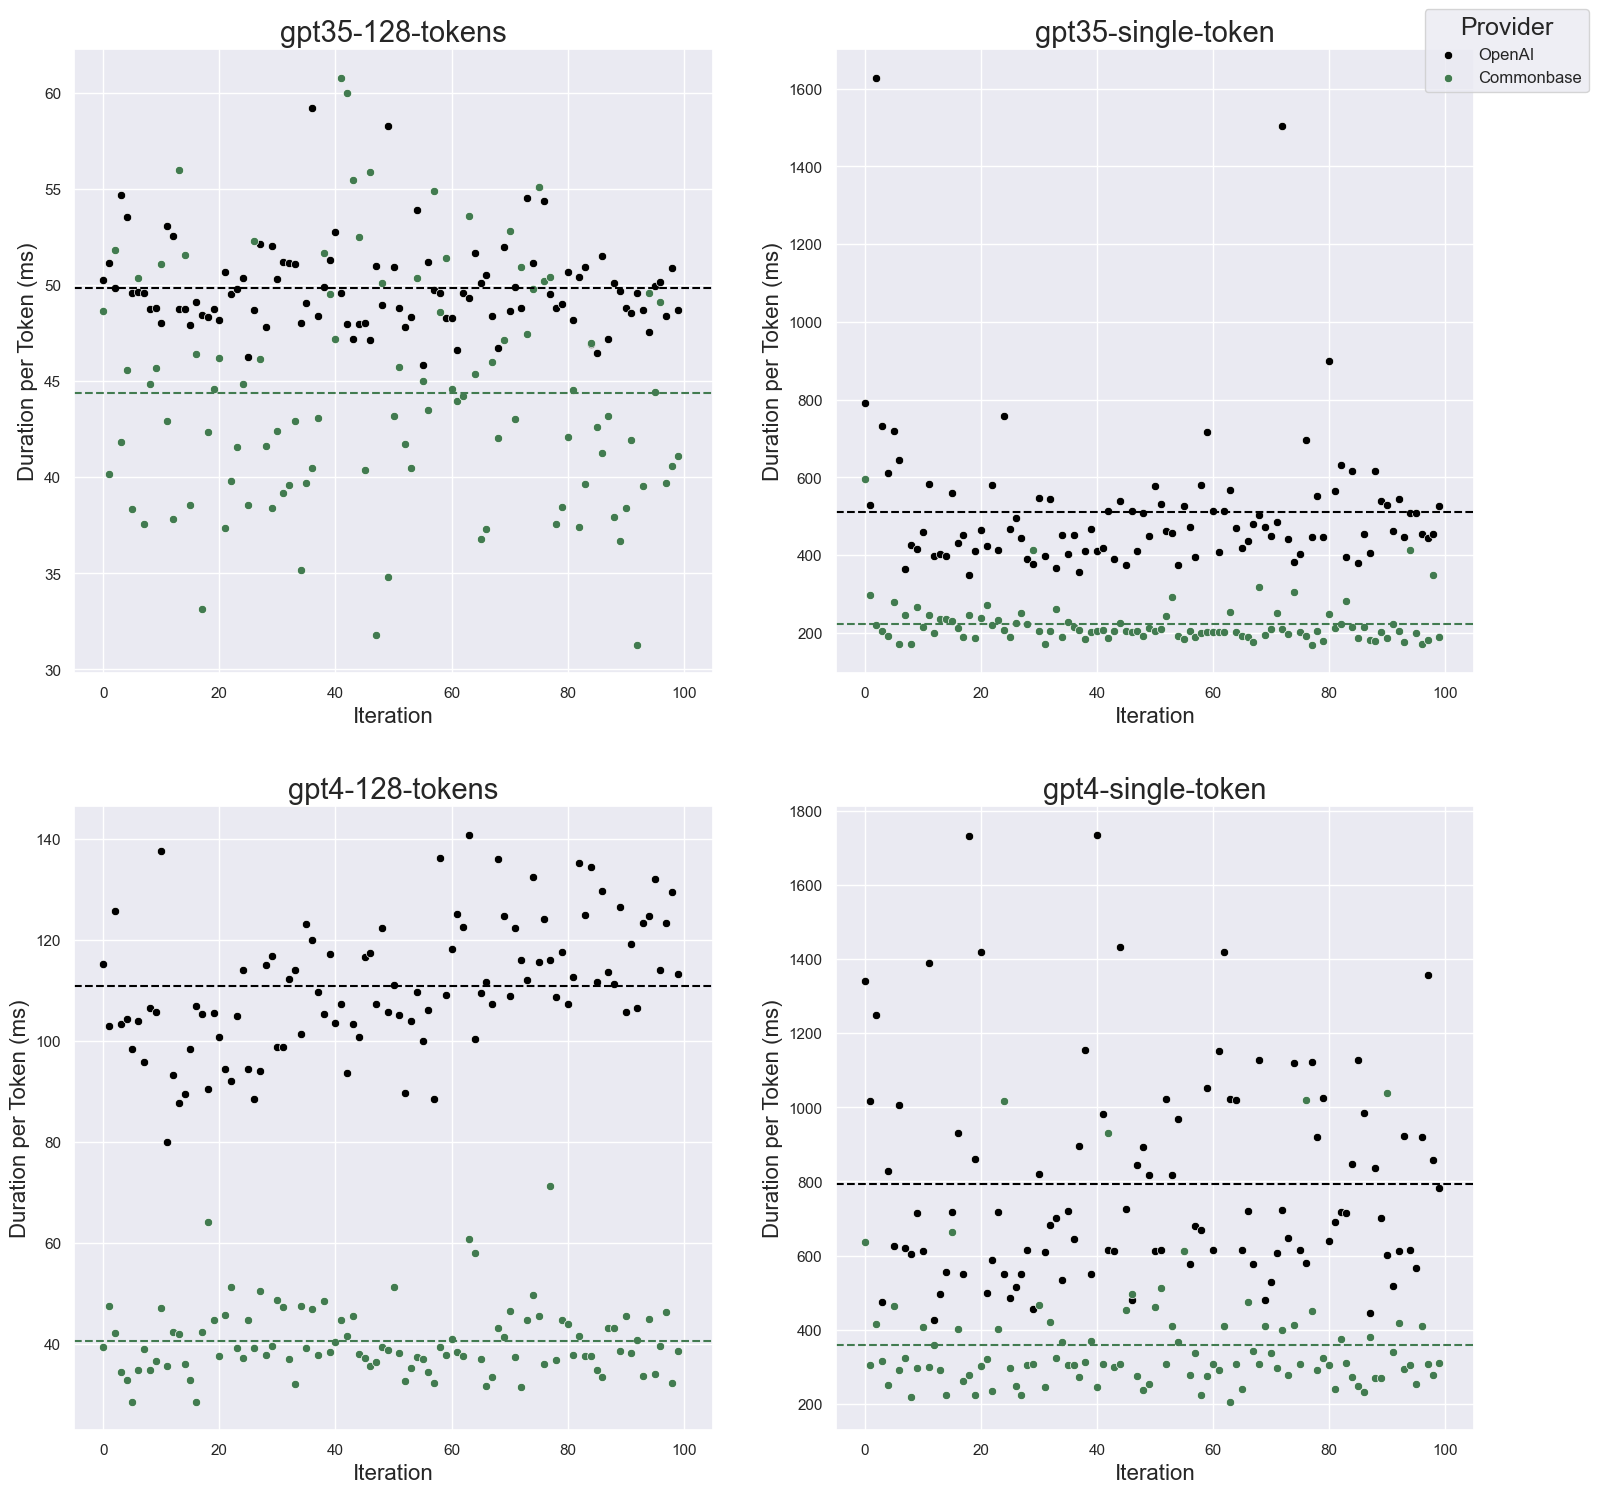

In [4]:
# get all benchmark names and sort them
allBenchmarks = data["benchmark"].unique()
allBenchmarks.sort()
allBenchmarks = allBenchmarks.tolist()

# automatically create a grid of plots
rows = math.ceil(len(allBenchmarks)/2)
fig = plt.figure(figsize=(15, rows*7.5,))
fig.subplots(rows, 2)

colorPalette = ["#000000", "#427B50"]

# helpers for combining legends
lines = []
labels = []

for ax in fig.axes:
    if len(allBenchmarks) == 0:
        break
    fName = allBenchmarks.pop(0)
    tmpData = data[data["benchmark"] == fName]

    oaiData = tmpData[tmpData["function"] == "callOpenai"]
    sns.scatterplot(ax=ax, data=oaiData, x="run", y="duration_per_token", color=colorPalette[0], label="OpenAI")
    ax.axhline(y=oaiData["duration_per_token"].mean(), ls='--', color=colorPalette[0])

    cbData = tmpData[tmpData["function"] == "callCommonbase"]
    sns.scatterplot(ax=ax, data=cbData, x="run", y="duration_per_token", color=colorPalette[1], label="Commonbase")
    ax.axhline(y=cbData["duration_per_token"].mean(), ls='--', color=colorPalette[1])

    ax.set_title(f"{fName}", fontsize=21)
    ax.set_xlabel("Iteration", fontsize=16)
    ax.set_xlim(-5, 105)
    ax.set_ylabel("Duration per Token (ms)", fontsize=16)
    lines, labels = ax.get_legend_handles_labels()
    ax.legend([],[], frameon=False)

fig.tight_layout(h_pad=3, w_pad=3)
legend = fig.legend(lines, labels, title="Provider", loc = "upper right", bbox_to_anchor=(1.07, 1), fontsize=12)
legend.get_title().set_fontsize(18)

Overall stats for all API calls

In [5]:
# overall statistics of all benchmarks
data2 = data.pivot(index=["benchmark", "run"], columns="function", values="duration_per_token")
data2["diff"] = data2["callCommonbase"] - data2["callOpenai"]
data2["ratio"] =  data2["callOpenai"] / data2["callCommonbase"]
data2.describe()

function,callCommonbase,callOpenai,diff,ratio
count,400.000000,400.000000,400.000000,400.000000
mean,166.569721,366.320679,-199.750958,2.204053
std,157.557272,347.377974,260.058774,1.007422
min,28.547433,45.852926,-1489.321792,0.541290
25%,41.627930,74.811144,-309.871698,1.316826
50%,120.335832,244.567809,-86.996853,2.147022
75%,250.157166,566.495427,-13.554057,2.848093
max,1039.614500,1735.487334,466.070458,7.340668


Overall stats for API calls that returned 128 tokens (realistic production use case)

In [25]:
data128 = data[data["benchmark"]\
    .isin(["gpt4-128-tokens", "gpt35-128-tokens"])]\
    .pivot(index=["benchmark", "run"], columns="function", values="duration_per_token")
data128["diff"] = data128["callCommonbase"] - data128["callOpenai"]
data128["ratio"] =  data128["callOpenai"] / data128["callCommonbase"]
data128.describe()

function,callCommonbase,callOpenai,diff,ratio
count,200.000000,200.000000,200.000000,200.000000
mean,42.490245,80.299627,-37.809382,1.971118
std,6.830845,31.867357,34.341377,0.913919
min,28.547433,45.852926,-98.073918,0.799641
25%,37.761539,49.594295,-71.437756,1.137130
50%,41.621425,69.612766,-24.848821,1.615883
75%,46.254674,109.429438,-5.983443,2.882946
max,71.233663,140.760160,12.023557,4.010471


Feel free to generate new csv files using the node.js script and run the notebook yourself to compare which numbers you get from the analysis.